# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [27]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-17 15:03:02--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-17 15:03:02--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1cf259b8ce7876bf121d248703.dl.dropboxusercontent.com/cd/0/inline/CNfYOSuPZqpwz_UUchSPFWEgwvlycW0QylJmfWGbkl_jOX3qaNIJK8RaXnJoptucnQT5VxHsZoJp4E4rUm6gv7MI6Tr7g4pGpFfCNADPVs-7N-1gs4F4zz2Te1zAnHohNJc/file# [following]
--2024-02-17 15:03:03--  https://uc1cf259b8ce7876bf121d248703.dl.dropboxusercontent.com/cd/0/inline/CNfYOSuPZqpwz_UUchSPFWEgwvlycW0QylJmfWGbkl_jOX3qaNIJK8RaXnJoptucnQT5VxHsZoJ

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

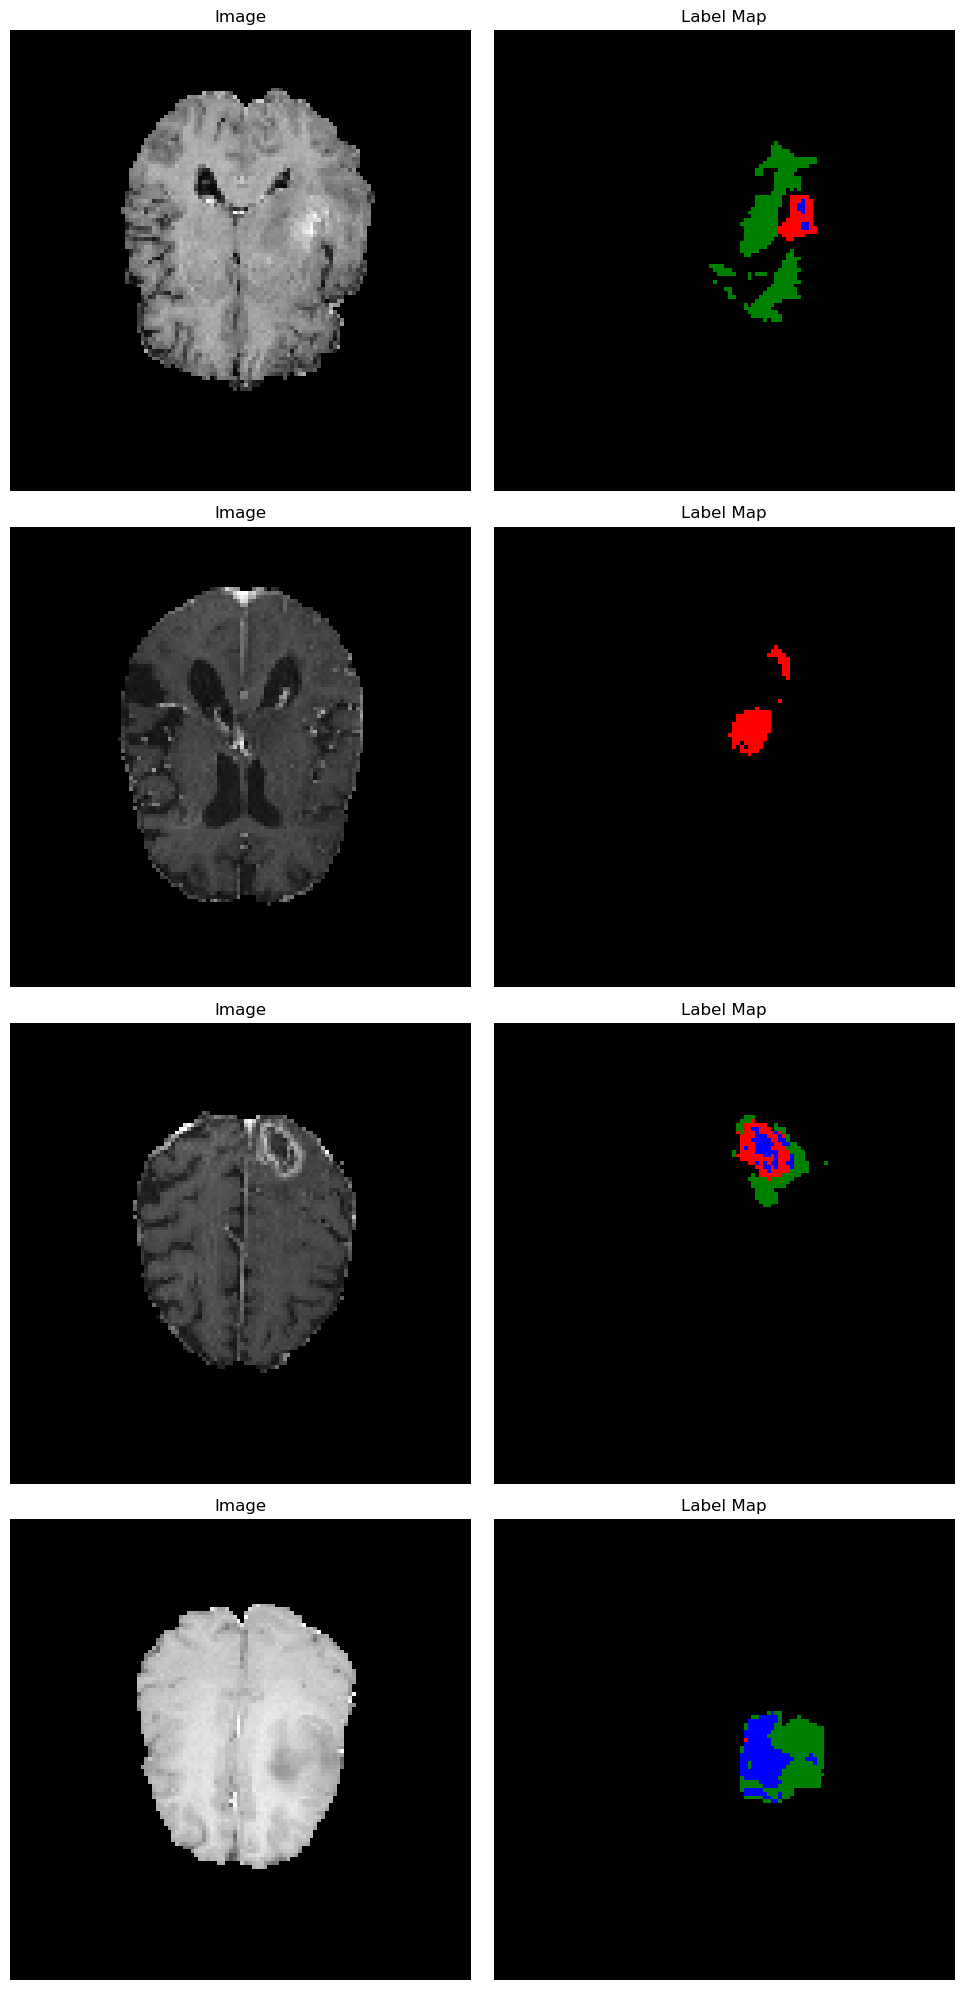

In [14]:
### Insert your code ###
image_dir = "./Task01_BrainTumour_2D/training_images/"
label_dir = "./Task01_BrainTumour_2D/training_labels/"
image_names = sorted(os.listdir(image_dir))

cmap_segmentation = colors.ListedColormap(['black', 'green', 'blue', 'red'])

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

idxs = random.sample(range(len(image_names)), k = 4)
for idx in range(4):
    image = imageio.v3.imread(image_dir + image_names[idxs[idx]])
    label_map = imageio.v3.imread(label_dir + image_names[idxs[idx]])

    axes[idx, 0].imshow(image, cmap='gray')
    axes[idx, 0].set_title('Image')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(label_map, cmap=cmap_segmentation)
    axes[idx, 1].set_title('Label Map')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [3]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.v3.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.v3.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        idxs = random.sample(range(self.__len__()), k = batch_size)
        for idx in idxs:
            image, label = self.__getitem__(idx)
            images.append(image)
            labels.append(label)
        images = [np.expand_dims(image, axis=0) for image in images]
        images = np.stack(images, axis=0)
        labels = np.stack(labels, axis=0)
        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [4]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        n //= 2  # 64
        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 32
        self.trans_conv2 = nn.Sequential(
            nn.Conv2d(4*n, 2*n, kernel_size=3, padding=1),
            nn.BatchNorm2d(int(2*n)),
            nn.ReLU(),
            nn.Conv2d(2*n, 2*n, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*n),
            nn.ReLU(),
            nn.ConvTranspose2d(2*n, n, kernel_size=2, stride=2),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 16
        self.trans_conv3 = nn.Sequential(
            nn.Conv2d(4*n, 2*n, kernel_size=3, padding=1),
            nn.BatchNorm2d(int(2*n)),
            nn.ReLU(),
            nn.Conv2d(2*n, 2*n, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*n),
            nn.ReLU(),
            nn.ConvTranspose2d(2*n, n, kernel_size=2, stride=2),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.trans_conv4 = nn.Sequential(
            nn.Conv2d(2*n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, output_channel, kernel_size=1)
        )
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.trans_conv1(x)
        x = self.trans_conv2(torch.cat((conv3_skip, x), dim=1))
        x = self.trans_conv3(torch.cat((conv2_skip, x), dim=1))
        x = self.trans_conv4(torch.cat((conv1_skip, x), dim=1))
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [31]:
# CUDA device
device = torch.device('mps' if torch.backends.mps.is_available() else
                      ('cuda' if torch.cuda.is_available() else 'cpu'))
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = criterion(logits, labels)
            print(f"Iteration {it}/{num_iter}, Test Loss: {loss.item()}")
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iteration 100/10000, Test Loss: 0.2993162274360657
Iteration 200/10000, Test Loss: 0.18226979672908783
Iteration 300/10000, Test Loss: 0.1514676809310913
Iteration 400/10000, Test Loss: 0.15451914072036743
Iteration 500/10000, Test Loss: 0.08054982870817184
Iteration 600/10000, Test Loss: 0.09077192842960358
Iteration 700/10000, Test Loss: 0.05468469113111496
Iteration 800/10000, Test Loss: 0.06369752436876297
Iteration 900/10000, Test Loss: 0.06116791442036629
Iteration 1000/10000, Test Loss: 0.046295925974845886
Iteration 1100/10000, Test Loss: 0.04089794680476189
Iteration 1200/10000, Test Loss: 0.0510476715862751
Iteration 1300/10000, Test Loss: 0.027244118973612785
Iteration 1400/10000, Test Loss: 0.04823531210422516
Iteration 1500/10000, Test Loss: 0.06008027121424675
Iteration 1600/10000, Test Loss: 0.059487272053956985
Iteration 1700/10000, Test Loss: 0.024661187082529068
Iteration 1800/10000, Test Loss: 0.05391591787338257
Iteration 1900/10000, Test Loss: 0.054314

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

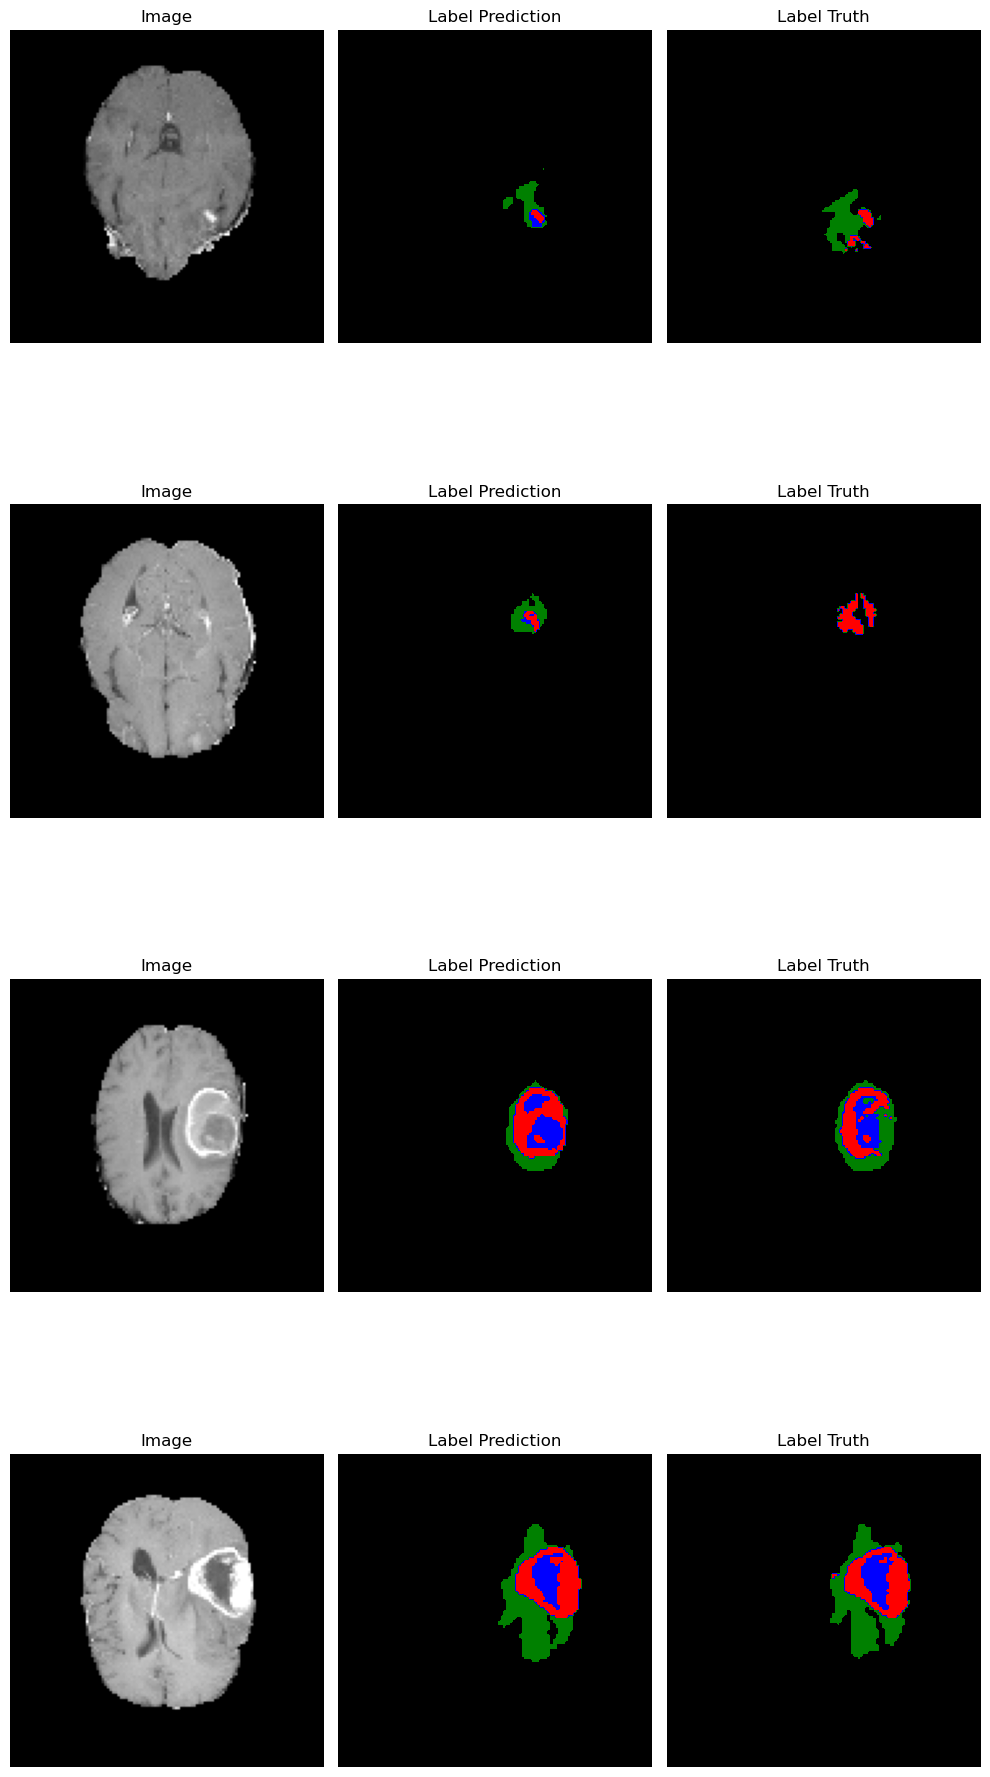

In [12]:
### Insert your code ###
num_class = 4
device = torch.device('mps' if torch.backends.mps.is_available() else
                      ('cuda' if torch.cuda.is_available() else 'cpu'))
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model.to(device)
model.load_state_dict(torch.load("./saved_models/model_10000.pt", map_location=torch.device(device)))
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')
images, labels = test_set.get_random_batch(4)
logits = model(torch.from_numpy(images).to(device, dtype=torch.float32))
logits_np = np.argmax(logits.detach().cpu().numpy(), axis=1)

cmap_segmentation = colors.ListedColormap(['black', 'green', 'blue', 'red'])
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 20))

for idx, (image, logit, label) in enumerate(zip(images, logits_np, labels)):
    axes[idx, 0].imshow(image.squeeze(), cmap='gray')
    axes[idx, 0].set_title('Image')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(logit, cmap=cmap_segmentation)
    axes[idx, 1].set_title('Label Prediction')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(label.squeeze(), cmap=cmap_segmentation)
    axes[idx, 2].set_title('Label Truth')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

This model showed a overall decreasing loss during training and obtained a loss around 0.03 ~ 0.06 after 10000 iterations. The model works well overall. The simplest way I could think of is using a larger training set. Also we can utilize some training techniques like cross validation, layer dropout, weight decay, and early stopping to prevent overfitting and optimize the training result. Also, from the randomly selected test above, I noticed that the model predicted quite precise result for some of them but some not. I would run seperate the test results into different categories, perhaps by the combination of the categories in the image, and investigate how the model performed on each of this catagories. Then try to see on which categories the model performed worse and try to maybe add more training data of that category. 

Other than that, we can perhaps use a larger U-Net model and see if that improves the performance.